# adVAE Tutorial: Generating Synthetic Gene Expression Profiles and MRI Images for Alzheimer's Disease


### Aim:

This tutorial demonstrates how to use `adVAE`, a variational autoencoder pipeline for generating synthetic gene expression data and MRI data. The tool can be applied to RNA microarray data as well as Gain-field corrected, atlas-registered average brain scans images from Alzheimer's Disease (AD) patients.

<br>

### Biological Question:

Can adVAE generate synthetic gene expression profiles and MRI images that retain biological characteristics of Alzheimer's gene expression patterns and MRI anatomical features associated with Alzheimer's Disease? Is this generated synthetic data useful for training classifier models that need to be trained on Alzheimer's-specific data?

<br>

### Dataset Used:

For the Gene Expression pipeline, I use a real RNA microarray dataset from the AMP-AD MSBB cohort, accessed via the AD Knowledge Portal.
- **Format**: RNA microarray expression values (.tsv)
- **Samples**: 20 brain samples from AD patients
- **Genes**: ~40,000 probes per sample
- **Preprocessing**: Scaled, PCA-reduced to preserve 95% variance
- **Source**: [AD Knowledge Portal](https://adknowledgeportal.synapse.org/)

For the MRI pipeline, I use real MRI data from the OASIS-1 dataset, containing structural brain scans from cognitively abnormal and Alzheimer's-affected individuals.

- **Format**: Gain-field corrected, atlas-registered average brain scans images (.img) > tensor 
- **Samples**: ~100 subjects, 20 slices each
- **Preprocessing**:
  - Gain-field corrected, atlas-registered average MRI volumes
  - Transverse slices extracted
  - Resized to 128x128 resolution
  - Converted to grayscale tensors
**Source:** [OASIS](https://sites.wustl.edu/oasisbrains/home/oasis-1/)

<br> 

### Installation:

Clone the repo and install dependencies.

```bash
git clone https://github.com/varnikaumashankar/adVAE.git
```

Alternatively, if the source distribution has been built using `python -m build`, one can directly install the package without cloning the repo:

```bash
pip install dist/advae-0.1.0.tar.gz
```

<br>

### Environment Setup:

**1. Create conda environment:** Ensure that your system has conda installed. On your terminal, run: `conda env create -f environment.yaml`  
**2. Activate conda environment:** Run: `conda activate adVAE`  
**3. Update dependencies in environment:** Run: `conda env update -f environment.yaml`

<br>

### Running the Pipeline on CL:

Use `main.py` to run preprocessing, training, evaluation, or synthetic data generation for either pipeline.

```bash
python main.py --pipeline gene_expression --task preprocess
python main.py --pipeline gene_expression --task train
python main.py --pipeline gene_expression --task evaluate
python main.py --pipeline gene_expression --task visualize
python main.py --pipeline gene_expression --task generate

python main.py --pipeline mri --task preprocess
python main.py --pipeline mri --task train
python main.py --pipeline mri --task grid_search
python main.py --pipeline mri --task evaluate
python main.py --pipeline mri --task visualize
python main.py --pipeline mri --task generate

```

All paths and parameters can be customized in `adVAE/config.py`.

### Results - Gene Expression Pipeline:

In [26]:
import pandas as pd
import matplotlib.pyplot as plt
import imageio.v3 as iio

In [27]:
gene_df = pd.read_csv("/Users/varnikaumashankar/Documents/UMich/Semester 2/BIOINF 576/adVAE/results/gene_expression/synthetic_gene_expression_2025-04-11.csv") # Load synthetic gene expression data
gene_df.head()

,k.all,k.in,k.out,k.diff,k.in.normed,k.all.normed,to.all,to.in,to.out,to.diff,to.in.normed,to.all.normed,standard.deviation
0,47.986118,11.355810,36.630308,-25.274498,0.011435,0.000879,127.630211,8.417577,119.212633,-110.795056,0.010582,0.002337,0.325178
1,64.960108,6.822038,58.138071,-51.316033,0.020800,0.001189,153.755123,3.809959,149.945164,-146.135205,0.016541,0.002815,0.441753
2,20.779403,9.234227,11.545176,-2.310949,-0.001354,0.000380,81.388157,5.399065,75.989092,-70.590027,0.001640,0.001490,0.172288
3,135.232346,43.041076,92.191270,-49.150195,0.023404,0.002476,299.579279,43.994937,255.584342,-211.589405,0.022111,0.005485,0.289958
4,44.540749,8.672925,35.867824,-27.194899,0.012735,0.000816,119.425131,5.529949,113.895182,-108.365232,0.011182,0.002187,0.358731


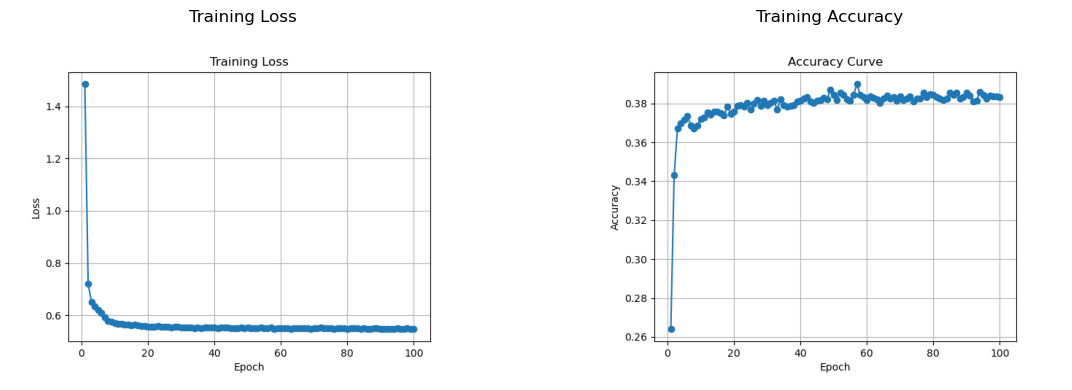

In [20]:
loss_path = "/Users/varnikaumashankar/Documents/UMich/Semester 2/BIOINF 576/adVAE/results/gene_expression/loss_curve_2025-04-11.png"
acc_path = "/Users/varnikaumashankar/Documents/UMich/Semester 2/BIOINF 576/adVAE/results/gene_expression/accuracy_curve_2025-04-11.png"

fig, axs = plt.subplots(1, 2, figsize=(12, 4))

axs[0].imshow(iio.imread(loss_path))
axs[0].set_title("Training Loss")
axs[0].axis("off")

axs[1].imshow(iio.imread(acc_path))
axs[1].set_title("Training Accuracy")
axs[1].axis("off")

plt.tight_layout()
plt.show()

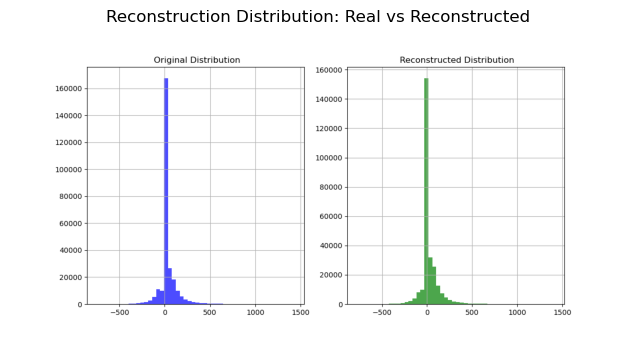

In [22]:
recon_dist_path = "/Users/varnikaumashankar/Documents/UMich/Semester 2/BIOINF 576/adVAE/results/gene_expression/reconstruction_distribution_2025-04-11.png" # Load and show reconstruction distribution image

img = iio.imread(recon_dist_path)
plt.figure(figsize=(8, 4))
plt.imshow(img)
plt.title("Reconstruction Distribution: Real vs Reconstructed")
plt.axis("off")
plt.show()


- The gene expression VAE was trained on PCA-reduced AMP-AD MSBB RNA microarray data, retaining 95% of the original variance. Over 100 epochs, the model demonstrated stable convergence with the training loss settling around 0.56 and reconstruction accuracy plateauing near 0.38. 
- The reconstructed data closely mirrored the original distribution, as confirmed by visual histograms and quantitative metrics: a mean absolute error of 3.26 and an average Pearson correlation of 0.9944. 
- These results suggest that the VAE effectively captures the global structure of gene expression patterns and is capable of generating biologically plausible synthetic profiles, making it a viable tool for data augmentation and robustness testing in downstream analyses.

### Results - MRI Expression Pipeline:

In [29]:
import os
import matplotlib.pyplot as plt
import glob
import imageio.v3 as iio
import numpy as np

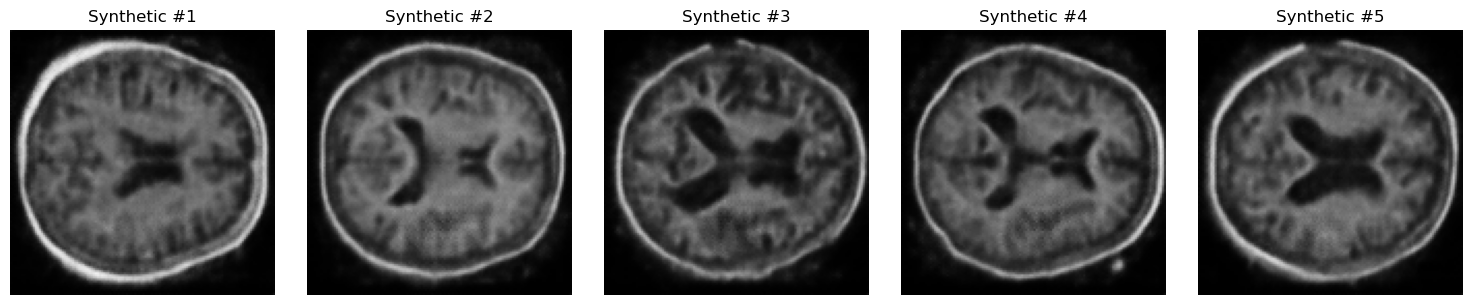

In [30]:
synthetic_dir = "/Users/varnikaumashankar/Documents/UMich/Semester 2/BIOINF 576/adVAE/results/mri/synthetic_gifs" # Directory where synthetic MRI slices were saved

gif_paths = sorted(glob.glob(os.path.join(synthetic_dir, "*.gif"))) # List all generated gif files

n = min(5, len(gif_paths))
fig, axs = plt.subplots(1, n, figsize=(15, 3))
for i, path in enumerate(gif_paths[:n]):
    img = iio.imread(path)  # shape: (1, H, W, 3)
    img = np.squeeze(img, axis=0)  # shape: (H, W, 3)
    axs[i].imshow(img)
    axs[i].set_title(f"Synthetic #{i+1}")
    axs[i].axis("off")
    
plt.tight_layout()
plt.show()

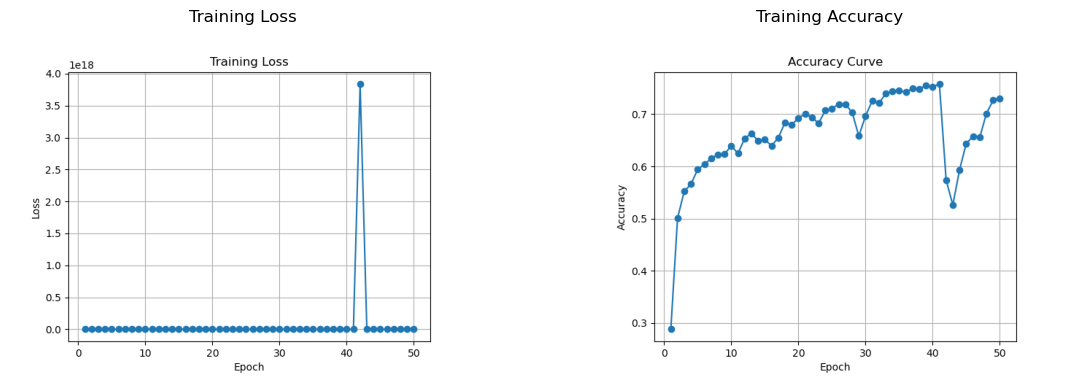

In [23]:
loss_path = "/Users/varnikaumashankar/Documents/UMich/Semester 2/BIOINF 576/adVAE/results/mri/loss_curve.png"
acc_path = "/Users/varnikaumashankar/Documents/UMich/Semester 2/BIOINF 576/adVAE/results/mri/accuracy_curve.png"

fig, axs = plt.subplots(1, 2, figsize=(12, 4))

axs[0].imshow(iio.imread(loss_path))
axs[0].set_title("Training Loss")
axs[0].axis("off")

axs[1].imshow(iio.imread(acc_path))
axs[1].set_title("Training Accuracy")
axs[1].axis("off")

plt.tight_layout()
plt.show()

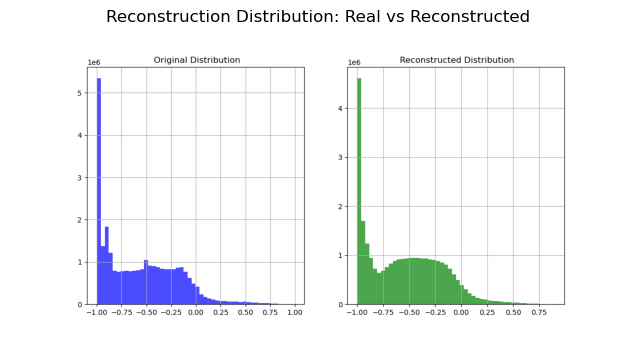

In [25]:
recon_dist_path = "/Users/varnikaumashankar/Documents/UMich/Semester 2/BIOINF 576/adVAE/results/mri/reconstruction_distribution.png"

img = iio.imread(recon_dist_path)
plt.figure(figsize=(8, 4))
plt.imshow(img)
plt.title("Reconstruction Distribution: Real vs Reconstructed")
plt.axis("off")
plt.show()

- The results from the MRI pipeline of the adVAE model demonstrate the tool’s capability to generate realistic synthetic 2D brain slices from Alzheimer’s MRI data. The synthetic outputs (Synthetic #1–#5) visually resemble real transverse MRI slices, capturing key structural contours like ventricle boundaries and cortical thickness. 
- The training accuracy steadily improved and reached approximately 0.74, suggesting good alignment between real and reconstructed slices. 
- However, the loss curve shows a spike near epoch 41, likely due to an unstable gradient or numerical explosion (possibly from a division by near-zero variance in a batch), which stabilized afterwards.
- The reconstruction distribution comparison shows that the synthetic distribution approximates the real pixel intensity distribution, though the real MRI data is more concentrated around extreme intensity values. 
- Overall, adVAE successfully learns to encode and reconstruct AD-associated brain structures from MRI slices, supporting its utility for generative neuroimaging tasks.